In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Oracle(cirq.Gate):
    def __init__(self, s):
        super(Oracle, self).__init__()
        self.s = s
        self.n = len(s)
    
    def _num_qubits_(self):
        return self.n + 1
    
    def _decompose_(self, qubits):
        s = self.s
        n = self.n

        for i, q in enumerate(qubits[:-1]):
            if s[i] == 1:
                yield cirq.CNOT(q, qubits[-1])

    def _circuit_diagram_info_(self, args):
        return ['U_f'] * (self.n + 1)

In [3]:
s = np.random.randint(2, size=3)
oracle = Oracle(s)
qubits = cirq.LineQubit.range(4)
circuit = cirq.Circuit(
    oracle(*qubits),
    cirq.measure(qubits[-1], key='result')
)
print(circuit)

0: ───U_f─────────────────
      │
1: ───U_f─────────────────
      │
2: ───U_f─────────────────
      │
3: ───U_f───M('result')───


In [4]:
sim = cirq.Simulator()

states = ['0b100', '0b010', '0b001']
results = []
for state in states:
    state = state + '0'
    result = sim.simulate(circuit, initial_state=int(state, 2))
    results.append(result.measurements['result'][0])

In [5]:
np.array_equal(results, s)

True

In [6]:
def bernstein_vazirani(oracle):
    n = oracle.n
    qubits = cirq.LineQubit.range(n + 1)
    circuit = cirq.Circuit(
        # Make the bottom qubit |->
        cirq.X(qubits[-1]),
        cirq.H(qubits[-1]),

        # Do the H^N operation
        cirq.Moment(cirq.H.on_each(*qubits[:-1])),

        # Query the oracle
        oracle(*qubits),

        # Do the H^N operation again
        cirq.Moment(cirq.H.on_each(*qubits[:-1])),

        # Measure
        cirq.measure(*qubits[:-1], key='result')
    )
    return circuit

In [7]:
circuit = bernstein_vazirani(oracle)
print(circuit)

0: ───────────H───U_f───H───M('result')───
                  │         │
1: ───────────H───U_f───H───M─────────────
                  │         │
2: ───────────H───U_f───H───M─────────────
                  │
3: ───X───H───────U_f─────────────────────


In [8]:
class Oracle(cirq.Gate):
    def __init__(self, n):
        super(Oracle, self).__init__()
        self.n = n
        self.s = np.random.randint(2, size=n)
    
    def _num_qubits_(self):
        return self.n + 1
    
    def _decompose_(self, qubits):
        s = self.s

        for i, q in enumerate(qubits[:-1]):
            if s[i] == 1:
                yield cirq.CNOT(q, qubits[-1])

    def _circuit_diagram_info_(self, args):
        return ['U_f'] * (self.n + 1)

In [9]:
def join_array_to_string(array):
    return ''.join([str(int(i)) for i in array])

In [10]:
def run_bv(n):
    oracle = Oracle(n)
    circuit = bernstein_vazirani(oracle)
    sim = cirq.Simulator()
    result = sim.run(circuit, repetitions=1000)
    return result.histogram(key='result', fold_func=join_array_to_string), oracle.s

In [11]:
result, s = run_bv(10)

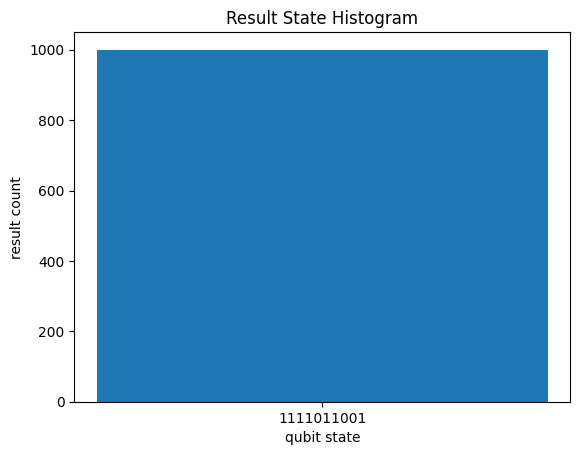

In [12]:
fig, ax = plt.subplots()
cirq.plot_state_histogram(result, ax=ax)
plt.show()

In [13]:
s

array([1, 1, 1, 1, 0, 1, 1, 0, 0, 1])